In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import default_cosmology
from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from cluster_local_new import ClusterLensing_fyp
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import corner

In [15]:
scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)



In [16]:
# getting the pixel scale list
pixscale_list = [0.2, 0.25, 0.25, 0.2, 0.2, 0.2]
z_l_list = [0.375, 0.308, 0.351, 0.397, 0.545, 0.543]
search_window_list = [90.1, 95, 100, 85, 100, 90]
x_center, y_center = [90, 75, 110, 70, 90, 70], [70, 80, 95, 60, 93, 65]
cluster = ClusterLensing_fyp(datax_list, datay_list, data_psi_list, 0.5, 1, pixscale_list, diff_z=False)

In [17]:
# compare the cluster class to lenstronomy
parameters = [67.5,81.0,3, 1] # x, y, z, index
cluster_img_dt = cluster.image_and_delay_for_xyz(parameters[0], parameters[1], parameters[2], parameters[3])
print(cluster_img_dt[0], cluster_img_dt[1])
print(cluster_img_dt[2])

# check with the lenstronomy package directly
realsize = 678
grid = np.linspace(0, realsize-1, realsize)
grid = grid * pixscale_list[parameters[3]]

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
D_S_candidate = cosmo.angular_diameter_distance(parameters[2])
D_LS_candidate = cosmo.angular_diameter_distance_z1z2(z_l_list[parameters[3]], parameters[2])
candidate_scale = D_LS_candidate / D_S_candidate
candidate_alpha_x = datax_list[parameters[3]] * candidate_scale
candidate_alpha_y = datay_list[parameters[3]] * candidate_scale
candidate_potential = data_psi_list[parameters[3]] * candidate_scale

candidate_kwargs = {
    'grid_interp_x': grid,
    'grid_interp_y': grid,
    'f_': candidate_potential * pixscale_list[parameters[3]]**2,
    'f_x': candidate_alpha_x,
    'f_y': candidate_alpha_y
}

lens_model_list2 = ['INTERPOL']
kwargs_lens2 = [candidate_kwargs]
lensModel_real = LensModel(lens_model_list=lens_model_list2, z_source=parameters[2], z_lens=z_l_list[parameters[3]], cosmo=cosmo)

# Use lens equation solver for verification
solver2 = LensEquationSolver(lensModel_real)
lens_img_po = solver2.image_position_from_source(
            parameters[0], parameters[1], kwargs_lens = kwargs_lens2,
            min_distance=pixscale_list[parameters[3]],
            search_window=search_window_list[int(parameters[3])],
            verbose=False,
            x_center=x_center[int(parameters[3])],
            y_center=y_center[int(parameters[3])]
        )
print(lens_img_po)
t_lenstronomy = lensModel_real.arrival_time(lens_img_po[0], lens_img_po[1], kwargs_lens2)
dt_lenstronomy = t_lenstronomy - t_lenstronomy.min()
print(dt_lenstronomy)

D_S: 1588.921 Mpc
D_LS: 1282.991 Mpc
Candidate scale: 0.807
[35.99429976 84.27536266 82.28667005 73.94518839 78.02650172] [90.11501046 59.67435186 83.09483137 66.51968297 76.18454922]
[    0.         10518.1548355  11253.56506444 11261.12186978
 11437.19019687]
(array([35.99429976, 84.27536266, 82.28667005, 73.94518839, 78.02650172]), array([90.11501046, 59.67435186, 83.09483137, 66.51968297, 76.18454922]))
[    0.         10518.1548355  11253.56506444 11261.12186978
 11437.19019687]


In [18]:
parameters = [80.1,99.9,3.3,65, 4] # x, y, z, H0, index
cluster_img_dt = cluster.image_and_delay_for_xyzH(parameters[0], parameters[1], parameters[2], parameters[3],parameters[4])
print(cluster_img_dt[0], cluster_img_dt[1])
print(cluster_img_dt[2])
cosmos_true = FlatLambdaCDM(H0=parameters[3], Om0=0.3)
lum_dist_true = cosmos_true.luminosity_distance(parameters[2]).value
print(lum_dist_true)

[42.52256514 87.4141065  99.49242593 64.5604116  57.26766576] [141.86323037  76.87579103  48.74807066  66.11302288  60.05745523]
[    0.         66177.45552811 77703.06428989 78147.33977794
 84187.25009436]
30697.06792044512


In [20]:
# luminosity distance
#print(cluster.luminosity_distance(parameters[2], parameters[3]))
guess = [80.1,99.9,3.3,65]
dt_test = cluster_img_dt[2]
print(f'true: {dt_test}')
print(f'guess: {cluster.image_and_delay_for_xyzH(guess[0], guess[1], guess[2], guess[3], parameters[4])[2]}')
chi_sq_test = cluster.chi_squared_with_z_Hubble(guess, dt_test, index=4, lum_dist_true=lum_dist_true)
print(chi_sq_test)

true: [    0.         66177.45552811 77703.06428989 78147.33977794
 84187.25009436]
guess: [    0.         66177.45552811 77703.06428989 78147.33977794
 84187.25009436]
0.0


In [ ]:
# sampling with z and H0
dt_test = cluster_img_dt[2]
print(dt_test)
DE_result = cluster.localize_known_cluster_diffevo_with_z_Hubble(dt_test, index = parameters[4], lum_dist_true= lum_dist_true)

In [ ]:
# DE + MCMC
print(lum_dist_true)
print(f'true: {dt_test}')
DE_result = cluster.localize_diffevo_then_mcmc_known_cluster_Hubble(dt_test, index = parameters[4],
                               # DE settings
                               early_stop=0.02,
                               # MCMC settings
                               n_walkers=16, n_steps=30000, burn_in=15000,
                               x_range_prior=10.0, y_range_prior=10.0,
                               x_range_int=2.0, y_range_int = 2.0, z_range_int = 0.3,
                               z_lower=2.0, z_upper=5,
                               # Hubble settings
                               H0_lower=43, H0_upper=102,
                               sigma=0.05,
                               sigma_lum = 0.05, lum_dist_true= lum_dist_true)

26444.94831469067
true: [    0.          1570.94028786 11552.539123   13584.43114229
 13861.10100891]
differential_evolution step 1: f(x)= 117328.97268841359
differential_evolution step 2: f(x)= 6490.714033405557
differential_evolution step 3: f(x)= 6490.714033405557
differential_evolution step 4: f(x)= 4144.502996645239
differential_evolution step 5: f(x)= 4144.502996645239
differential_evolution step 6: f(x)= 4144.502996645239
differential_evolution step 7: f(x)= 557.6177483968443
differential_evolution step 8: f(x)= 557.6177483968443
differential_evolution step 9: f(x)= 79.26064626869203
differential_evolution step 10: f(x)= 79.26064626869203
differential_evolution step 11: f(x)= 79.26064626869203
differential_evolution step 12: f(x)= 79.26064626869203
differential_evolution step 13: f(x)= 74.62441758788415
differential_evolution step 14: f(x)= 35.89552372786315
differential_evolution step 15: f(x)= 35.89552372786315
differential_evolution step 16: f(x)= 21.798086695900388
different

100%|██████████| 5000/5000 [2:37:58<00:00,  1.90s/it]  

MCMC median after DE: x=109.94, y=90.09, z=3.11, H0=70.61


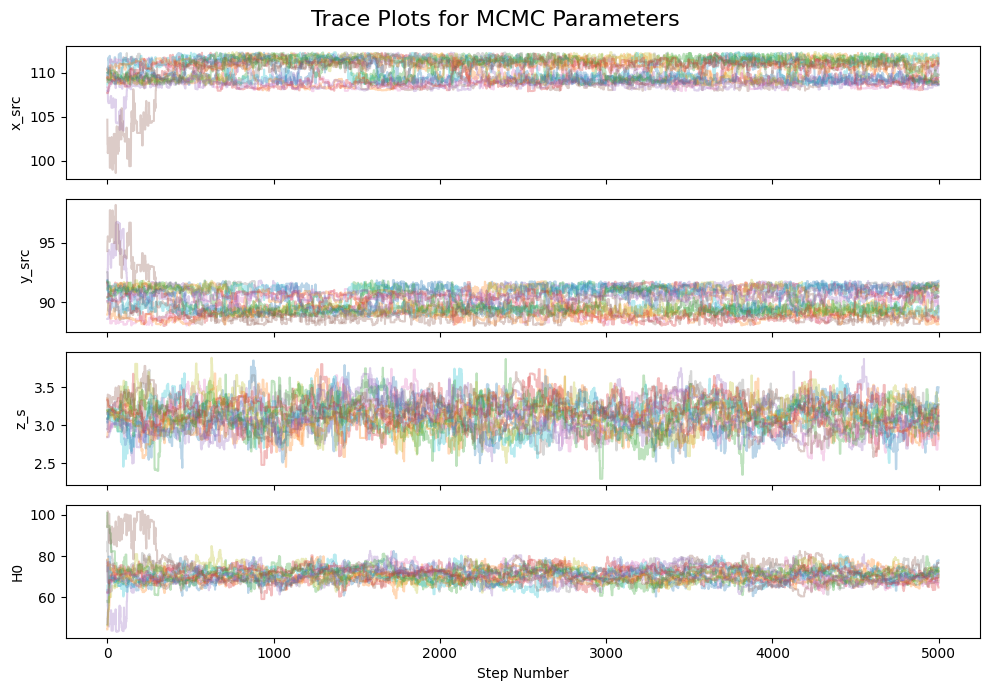

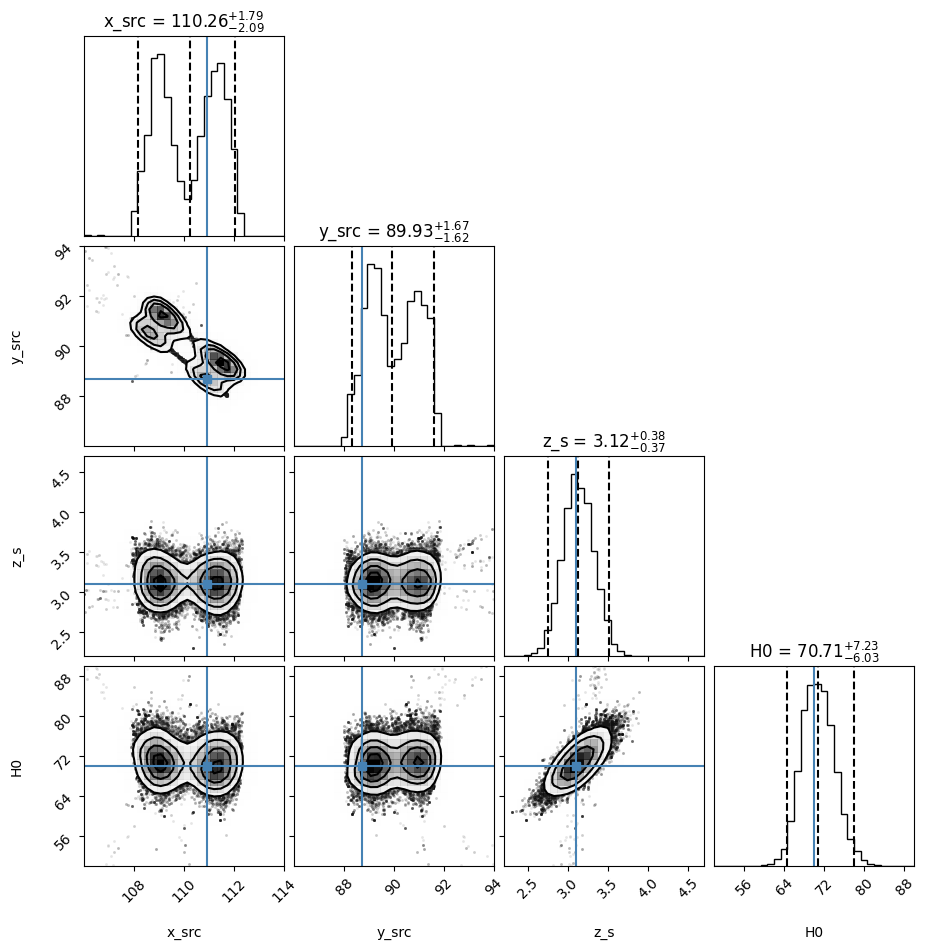

In [ ]:
opt_sampler = DE_result[2]

burn_in = 2500
chain = opt_sampler.get_chain(flat=False)
log_probs = opt_sampler.get_log_prob(discard=burn_in, flat=True)
n_steps, n_walkers, ndim = chain.shape
labels = ["x_src", "y_src", "z_s", "H0"]

# --- Plot Trace Plots ---
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    for walker in range(n_walkers):
        ax.plot(chain[:, walker, i], alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step Number")
plt.suptitle("Trace Plots for MCMC Parameters", fontsize=16)
plt.tight_layout()
plt.savefig('de_mcmc/0.05dt/z_H0/de_mcmc_trace_0.05dt_H0_2.pdf')
plt.show()

# --- Plot Corner Plot ---
# Flatten the chain (each walker’s chain concatenated) after burn-in.
flat_samples = opt_sampler.get_chain(flat=True)

figure = corner.corner(
    flat_samples,
    labels=labels,
    quantiles=[0.025, 0.5, 0.975],  # 95% interval
    show_titles=True,
    truths=[parameters[0], parameters[1], parameters[2], parameters[3]],  # True values
    range=[[106, 114], [86, 94], [2.2, 4.7], [50, 90]],  # Range for each parameter
    smooth=1.0,  # Smooth out contours
    bins=30,     # Increase the number of bins
)

plt.savefig('de_mcmc/0.05dt/z_H0/de_mcmc_corner_0.05dt_H0_2.pdf')
plt.show()

In [13]:
flat_samples = opt_sampler.get_chain(discard=2500, flat=True)
log_probs = opt_sampler.get_log_prob(discard=2500, flat=True)

# Find best by likelihood
best_idx_ll = np.argmax(log_probs)
best_params_ll = flat_samples[best_idx_ll]

# Choose best_params (here by smallest likelihood)
best_params = best_params_ll
print("Best parameters (by likelihood):", best_params)
chi_sq = cluster.chi_squared_with_z_Hubble(best_params, dt_test, index=parameters[4], lum_dist_true=lum_dist_true)
print(f'chi_sq: {chi_sq}')

Best parameters (by likelihood): [109.12331908  91.25433101   3.10023735  70.43038917]
chi_sq: 0.03283373354644417
